In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
img_width, img_height = 224, 224
epochs = 30
batch_size = 32
n_classes = 6

In [3]:
!pip install --upgrade transformers datasets
!pip install --upgrade peft
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
import csv
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import ViTFeatureExtractor, ViTForImageClassification
from datasets import load_dataset
import torch
import seaborn as sn

In [4]:
dataset = load_dataset('imagefolder', data_dir='/content/drive/My Drive/datasets/five-fold-cv6/fold-5/')
data_dir = '/content/drive/My Drive/datasets/five-fold-cv6/fold-5/'
train_data_dir = data_dir + '1234-as-training/'
validation_data_dir = data_dir + '5-as-test/'

Resolving data files:   0%|          | 0/2569 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/761 [00:00<?, ?it/s]

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2569 images belonging to 6 classes.
Found 761 images belonging to 6 classes.


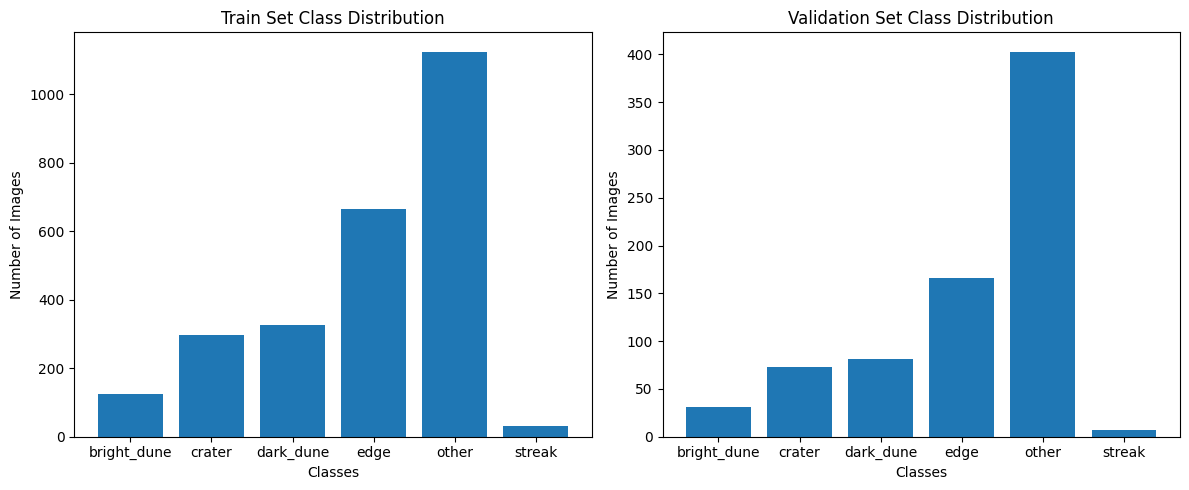

In [6]:
# Get class counts for train_generator
train_class_counts = np.bincount(train_generator.classes)

# Get class counts for validation_generator (test_generator)
val_class_counts = np.bincount(validation_generator.classes)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for train_generator
axes[0].bar(class_labels, train_class_counts)
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Train Set Class Distribution')

# Plot histogram for validation_generator
axes[1].bar(class_labels, val_class_counts)
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Validation Set Class Distribution')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [10]:
# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch32-224-in21k')

# Load the pre-trained ViT-B/32 model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch32-224-in21k', num_labels=6) # Changed to ViTForImageClassification

# Reset the id2label and label2id mappings in the config
model.config.id2label = {i: str(i) for i in range(6)}  # Update this if you have specific class names
model.config.label2id = {str(i): i for i in range(6)} # Update this if you have specific class names

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch32-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def preprocess_function(examples):
    # Convert images to RGB format if they are not already
    examples['image'] = [img.convert('RGB') for img in examples['image']]
    examples['pixel_values'] = feature_extractor(examples['image'], return_tensors='pt').pixel_values
    return examples

dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2569 [00:00<?, ? examples/s]

Map:   0%|          | 0/761 [00:00<?, ? examples/s]

In [12]:
!pip install --upgrade transformers

from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./vit-image-classification",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    num_train_epochs=3,
    fp16=True,
    logging_dir='/content/drive/My Drive/Training logs/',  # Save logs to a local directory
    learning_rate=2e-5,
    save_total_limit=2,
    report_to="none"  # Disable reporting to external services like wandb
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
)

train_results = trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.475673
2,No log,0.332218
3,No log,0.313301


In [13]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.3133014738559723, 'eval_runtime': 263.0792, 'eval_samples_per_second': 2.893, 'eval_steps_per_second': 0.365, 'epoch': 3.0}


In [14]:
predictions = trainer.predict(dataset['test'])

In [15]:
predicted_labels = np.argmax(predictions.predictions, axis=1)

In [16]:
true_labels = predictions.label_ids

Confusion Matrix


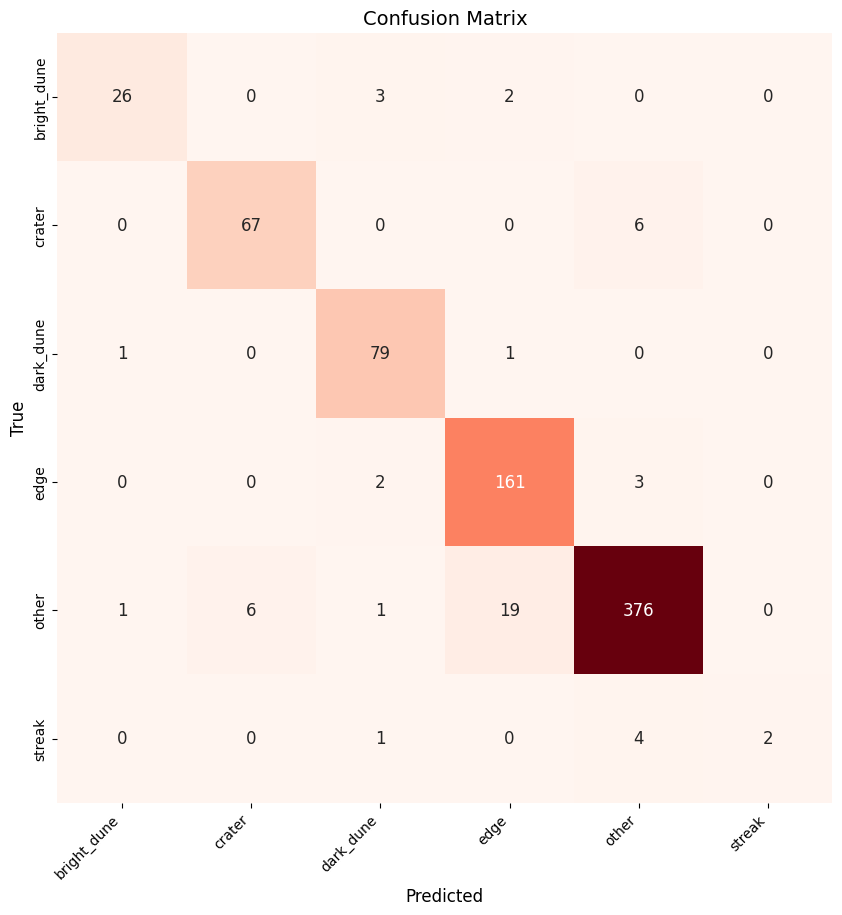

              precision    recall  f1-score   support

 bright_dune       0.93      0.84      0.88        31
      crater       0.92      0.92      0.92        73
   dark_dune       0.92      0.98      0.95        81
        edge       0.88      0.97      0.92       166
       other       0.97      0.93      0.95       403
      streak       1.00      0.29      0.44         7

    accuracy                           0.93       761
   macro avg       0.94      0.82      0.84       761
weighted avg       0.94      0.93      0.93       761



In [17]:
# Get the class labels
class_labels = list(train_generator.class_indices.keys())

#show results
print('Confusion Matrix')
# Access the predictions from the PredictionOutput object and convert to NumPy array
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Assuming validation_generator.classes contains the true labels for your validation data
confusion = confusion_matrix(validation_generator.classes, predicted_labels)

# Adjust figure size for better visibility
plt.figure(figsize=(10, 10))  # Reduced figure size

# Create heatmap with annotations and labels
sn.heatmap(confusion, annot=True, fmt="d", cmap="Reds", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 12})  # Increased font size for annotations

plt.xlabel('Predicted', fontsize=12)  # Increased font size for x-axis label
plt.ylabel('True', fontsize=12)  # Increased font size for y-axis label
plt.title('Confusion Matrix', fontsize=14)  # Increased font size for title
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotated x-axis labels for better readability
plt.yticks(fontsize=10)  # Increased font size for y-axis labels
plt.show()

# Generate and print classification report
report = classification_report(true_labels, predicted_labels, target_names=dataset['train'].features['label'].names)
print(report)